# Task 3
Extract the following data from the graph generated in Task 2:
 1. Total length of the transport network
 2. The average distance between the stations
 3. The standard deviation of the distances between the stations


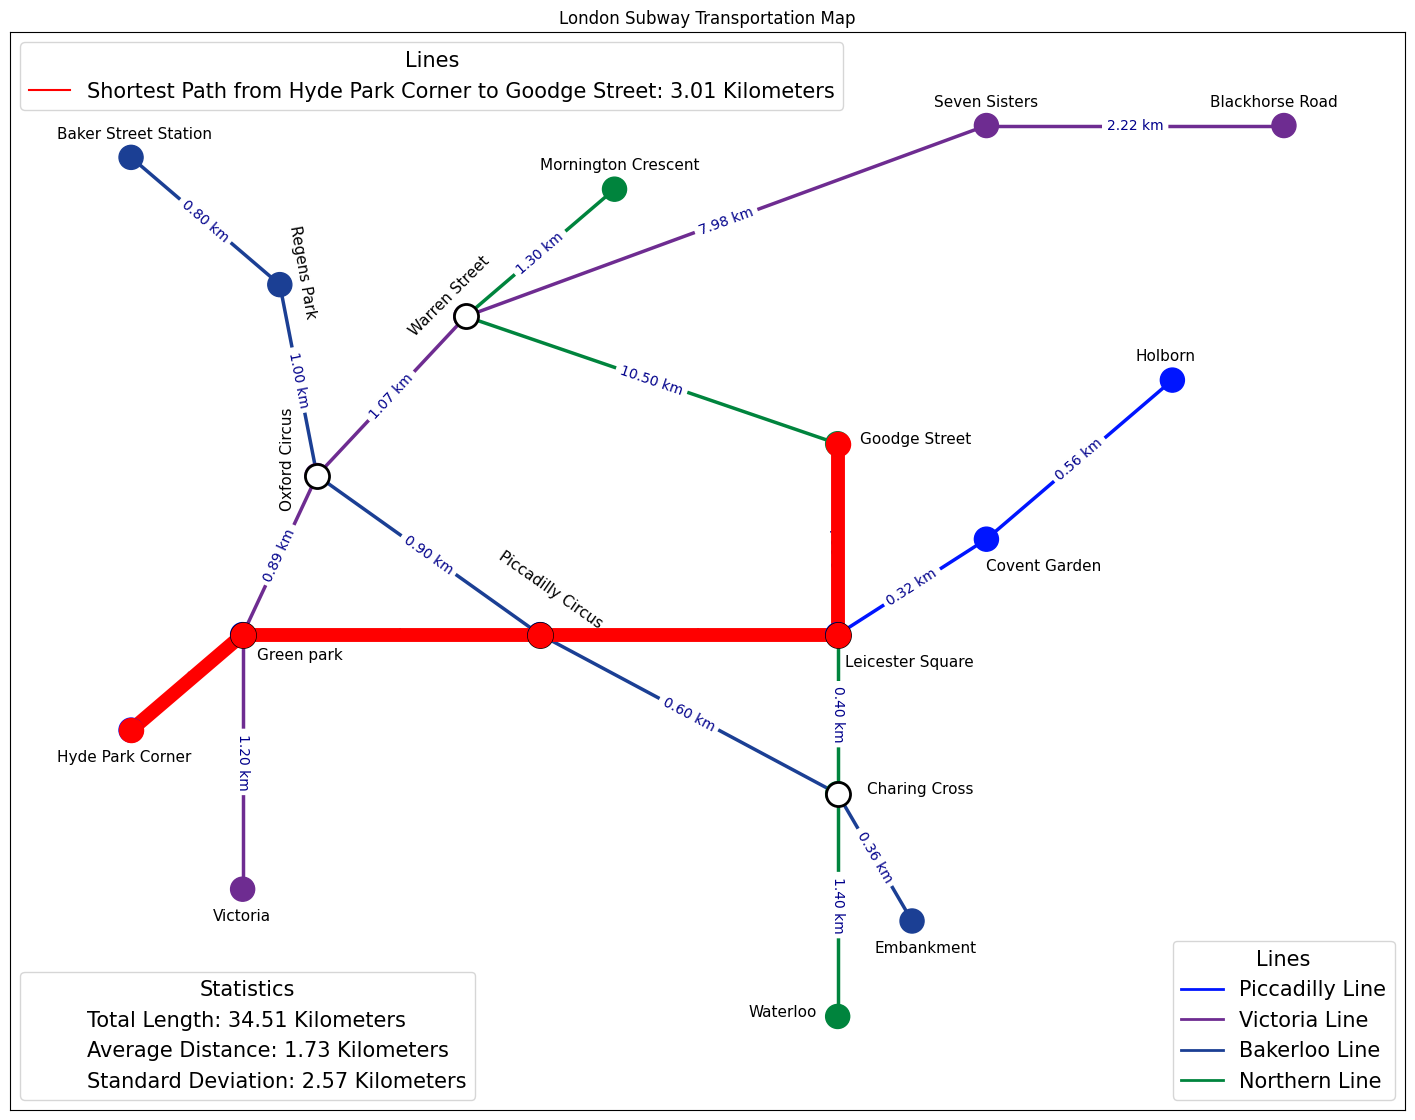

In [108]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd


def draw_node_labels(edge_label_coords: list[dict], text_size: int = 11):
    for item in edge_label_coords:
        rotation = item.get("rotation", 0)
        plt.text(item["pos"]["x"], item["pos"]["y"], s=item["s"], size=text_size, rotation=rotation)


class MapGraph(nx.Graph):
    def add_node_to_graph(self, df):
        for index, row in df.iterrows():
            self.add_node(row["Station"], npos=(row["Latitude"], row["Longitude"]), ccn=row["Color"])
    
    def add_edge_to_graph(self, df):
        for index, row in df.iterrows():
            distance = row["Distance"]
            if row["Unit"] == "m":
                distance /= 1000
            self.add_edge(row["StartStation"], row["EndStation"], distance=f"{distance:.2f} km", cce=row["Color"], weight=round(distance,2))


col_names = ["Station", "Latitude", "Longitude", "Color"]
subway_df = pd.read_csv("subway_station_dataset.csv", usecols=col_names, na_values=["N/A", "Unknown"])
subway_df.dropna()
subway_df.drop_duplicates()

distance_df_colname = ["StartStation", "EndStation", "Distance", "Unit", "Color"]
distance_df = pd.read_csv("subway_station_distance.csv", usecols=distance_df_colname, na_values=["N/A", "Unknown"])
subway_df.dropna()
subway_df.drop_duplicates()

G = MapGraph()

G.add_node_to_graph(subway_df)
G.add_edge_to_graph(distance_df)

# Get positions from node attributes
pos = nx.get_node_attributes(G, 'npos')
node_colour = nx.get_node_attributes(G, 'ccn')
edge_colour = nx.get_edge_attributes(G, 'cce')

node_colours = list(node_colour.values())
edge_colours = list(edge_colour.values())

intersecting_nodes = ["Green Park", "Piccadilly Circus", "Oxford Circus", "Charing Cross", "Leicester Square", "Warren Street"]

# Plotting
plt.figure(figsize=(18, 14))

# Draw Network
nx.draw_networkx(G, pos, node_color=node_colours, with_labels=False)

# Draw Nodes
nx.draw_networkx_nodes(G, pos, nodelist=intersecting_nodes, node_color='white', edgecolors='black', linewidths=2, node_size=300)

# Draw Edges
nx.draw_networkx_edges(G, pos, edge_color=edge_colours, width=2.5)

# Draw edge labels with distances
edge_labels = nx.get_edge_attributes(G, 'distance')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_color='darkblue')

text_size = 11
edge_label_coords = [
    # Piccadilly Label
    {"s": "Hyde Park Corner", "pos": {"x": 25, "y": 30}},
    {"s": "Green park", "pos": {"x": 52, "y": 46}},
    {"s": "Piccadilly Circus", "pos": {"x": 84, "y": 51}, "rotation": -35},
    {"s": "Leicester Square", "pos": {"x": 131, "y": 45}},
    {"s": "Covent Garden","pos": {"x": 150, "y": 60}},
    {"s": "Holborn", "pos": {"x": 170, "y": 93}},
    # Victoria Line Label
    {"s": "Victoria", "pos": {"x": 46, "y": 5}},
    {"s": "Oxford Circus", "pos": {"x": 55, "y": 70}, "rotation": 90},
    {"s": "Warren Street", "pos": {"x": 72, "y": 97}, "rotation": 45},
    {"s": "Seven Sisters", "pos": {"x": 143, "y": 133}},
    {"s": "Blackhorse Road", "pos": {"x": 180, "y": 133}},
    # Bakerloo Line Label
    {"s": "Embankment", "pos": {"x": 135, "y": 0}},
    {"s": "Charing Cross", "pos": {"x": 134, "y": 25}},
    {"s": "Regens Park", "pos": {"x": 56, "y": 100}, "rotation": 280},
    {"s": "Baker Street Station", "pos": {"x": 25, "y": 128}},
    # Northern Line Label
    {"s": "Waterloo", "pos": {"x": 118, "y": -10}},
    {"s": "Goodge Street", "pos": {"x": 133, "y": 80}},
    {"s": "Mornington Crescent", "pos": {"x": 90, "y": 123}},
]

draw_node_labels(edge_label_coords, text_size=text_size)

total_length = round(G.size(weight="weight"), 2)
average_length = round(total_length / G.size(), 2)

weights = [d["weight"] for (u, v, d) in G.edges(data=True)]
std_distances = round(np.std(weights), 2)

path = nx.shortest_path(G, source="Hyde Park Corner", target="Goodge Street", weight='weight')
path_edges = list(zip(path, path[1:]))

shortet_path_length = round(nx.dijkstra_path_length(G, 'Hyde Park Corner', 'Goodge Street'), 2)

nx.draw_networkx_nodes(G,pos,nodelist=path, node_color='r')
nx.draw_networkx_edges(G,pos,edgelist=path_edges, edge_color='r', width=10)

# Add custom legend for the lines
line_labels = [
    Line2D([0], [0], color='#0015ff', lw=2, label='Piccadilly Line'),
    Line2D([0], [0], color='#6e2c91', lw=2, label='Victoria Line'),
    Line2D([0], [0], color='#1b3f94', lw=2, label='Bakerloo Line'),
    Line2D([0], [0], color='#00843d', lw=2, label='Northern Line'),
]

line_labels_legend = plt.legend(handles=line_labels, loc='lower right', title="Lines", fontsize=15, title_fontsize=15)
shortest_path_labels = [Line2D([0], [0], color='red', label=f'Shortest Path from Hyde Park Corner to Goodge Street: {shortet_path_length} Kilometers'),]
shortest_path_legend = plt.legend(handles=shortest_path_labels, loc='upper left', title="Lines", fontsize=15, title_fontsize=15)

# Add the first legend back to the plot
plt.gca().add_artist(line_labels_legend)
plt.gca().add_artist(shortest_path_legend)

stats_labels = [
    Line2D([0], [0], color='white', label=f'Total Length: {total_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Average Distance: {average_length:.2f} Kilometers'),
    Line2D([0], [0], color='white', label=f'Standard Deviation: {std_distances:.2f} Kilometers'),
]
stats_legend = plt.legend(handles=stats_labels, loc='lower left', title="Statistics", fontsize=15, title_fontsize=15)


# Display the title and remove axes
plt.title("London Subway Transportation Map")

#Save Graph to image
plt.savefig("task3.png")
plt.show()